In [0]:
import pandas as pd
from google.colab import files 



In [0]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set()
%matplotlib inline

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('opendata_tess_ow.csv')  
org= pd.read_csv('opendata_tess_ow.csv')

In [0]:
#copying data into new dataframe
h = org.copy()



# **Exploratory** **data analysis and data manipulation**

In [0]:
#checking for null values
h.isnull().sum()

YEAR_NUM                                           0
MNTH                                               0
PROGRAM_NM                                         0
OFFICE                                             0
FAMILY_TYP_NM                                      0
FAMILY_SIZE                                        0
AGE                                                0
EDUCATION_LEVEL                                    0
EARNINGS                                     8646885
IMMIGRATION_STATUS                                 0
TIMES_ON_ASSISTANCE                                0
MONTHS_ON_ASSISTANCE                               0
MONTHS_OFF_ASSISTANCE                              0
GENDER                                             0
SHELTER_COSTS                                      0
YOUNGEST_DEP_AGE_RANGE                             0
WARD_SCODE                                     43661
CENSUS_NEIGH_SCODE                             43661
NEW_CASES                                     

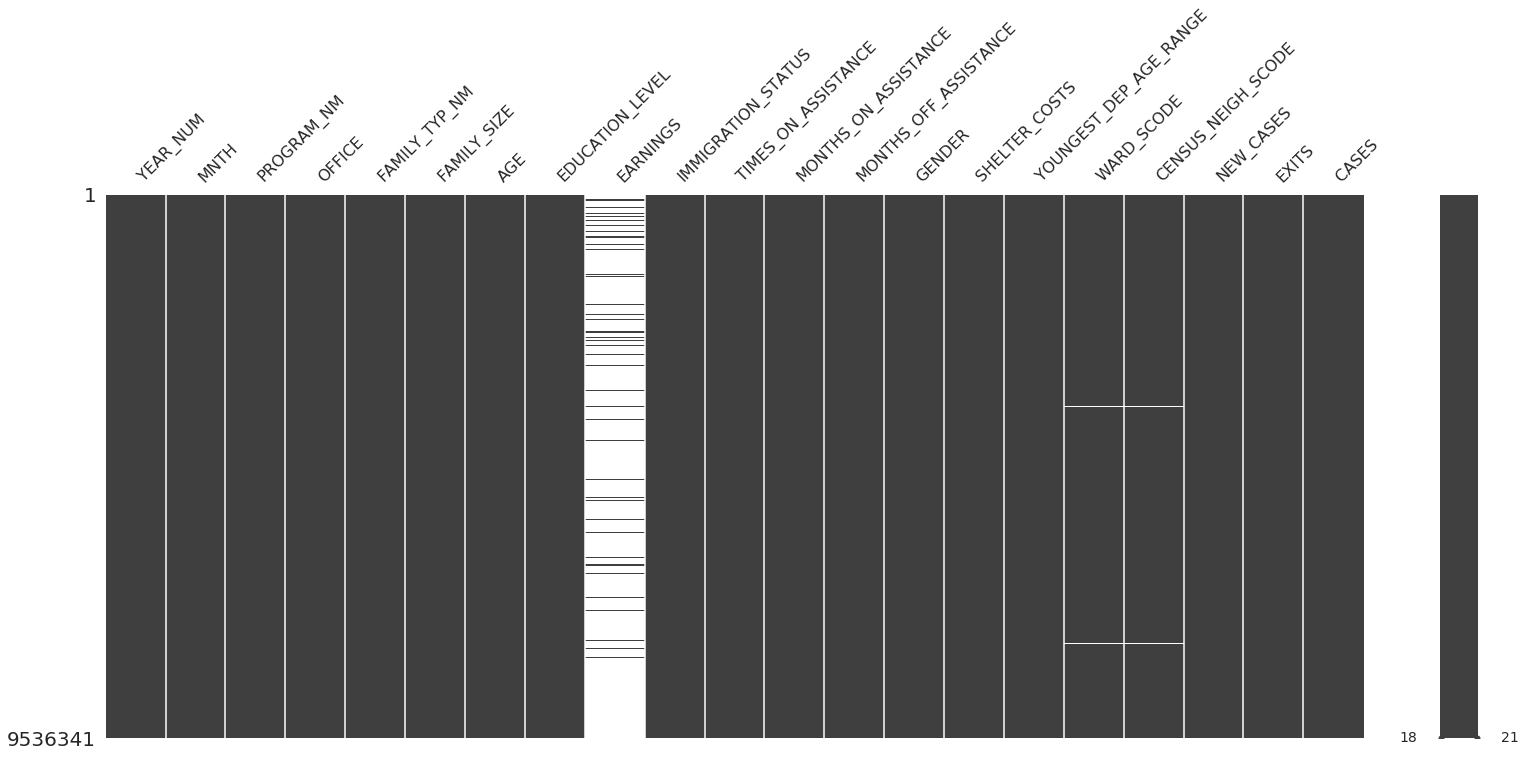

In [0]:
import missingno as msno
msno.matrix(org)

In [0]:
 # Using whole data to form an exhaustive list of levels
for col in h.columns.values:
    if h[col].dtypes=='object':
           print(h[col].value_counts())

Ontario Works    9536341
Name: PROGRAM_NM, dtype: int64
Malvern Employment & Social Services               1022320
Golden Mile Employment & Social Services            889935
Lawrence Square Employment & Social Services        840558
York Humber Employment & Social Services            802587
Kennedy Employment & Social Services                794095
The Queensway Employment & Social Services          737263
Lesmill Employment & Social Services                588127
Wellesley Place Employment & Social Services        567157
Attwell Employment & Social Services                565759
Yonge Eglinton Employment & Social Services         538875
Chesswood Employment & Social Services              531464
High Park Parkdale Employment & Social Services     506204
Metro Hall Employment & Social Services             361545
Consilium Employment & Social Services              347591
Beaches Employment & Social Services                345256
Application Centre                                   96487


* FAMILY_SIZE - there are two classes with same family size=1. It will be combined into one. 

* PROGRAM_NM -  Program name has only one class value(Ontario works). We wont include this in our analysis.

* YEAR_NUM, MNTH - Our analysis is not time based but instead focusses on the aggregated data of last ten years. Hence, these columns would be dropped.

* EDUCATION_LEVEL - it has a UNKNOWN class with count = 161410. The education level column will be dropped.

* EARNINGS, WARD_SCODE, CENSUS_NEIGH_SCODE have lots of NULL VALUES. These columns will be dropped.




In [0]:
h['FAMILY_SIZE'] = np.where(h['FAMILY_SIZE'] =='4+',h['FAMILY_SIZE'],
                            np.where(h['FAMILY_SIZE'] =='4',h['FAMILY_SIZE'],
                                     np.where(h['FAMILY_SIZE'] =='3',h['FAMILY_SIZE'],
                                              np.where(h['FAMILY_SIZE'] =='2',h['FAMILY_SIZE'],'1'))))

h.rename(columns = {'OFF':'OFFICE','CASES                                    ':'CASES'}, inplace = True)




h.drop(["YEAR_NUM","MNTH","PROGRAM_NM","EARNINGS","WARD_SCODE","CENSUS_NEIGH_SCODE","EDUCATION_LEVEL","FAMILY_TYP_NM",],axis =1 , inplace =True)
h_agg=h.groupby([ 'OFFICE',  'FAMILY_SIZE', 'AGE', 'IMMIGRATION_STATUS', 'TIMES_ON_ASSISTANCE','MONTHS_ON_ASSISTANCE', 'MONTHS_OFF_ASSISTANCE', 'GENDER',
       'SHELTER_COSTS', 'YOUNGEST_DEP_AGE_RANGE'],as_index=False).sum()
h=h_agg.copy()

h.shape

(326613, 13)

Creating outcome variable = EXIT_BINARY 
There will be two classes. 0,1
EXIT_BINARY represent whether a particular household has exited assistance program or not.

We will drop EXITS,CASES and NEW_CASES, as these are not required for further analysis.

In [0]:
h['EXIT_BINARY']=np.where(h['EXITS']==0,0,1)
h.drop(["CASES","NEW_CASES"],axis=1,inplace=True)
h.drop(["EXITS"],axis=1,inplace=True)

In [0]:
h.head(10)
h.shape

(9536341, 21)

Separating features and labels


In [0]:
X = h.iloc[:,0:10]  
y=h['EXIT_BINARY'].to_frame()
X.head()
y.head()
X.dtypes


OFFICE                    object
FAMILY_SIZE               object
AGE                       object
IMMIGRATION_STATUS        object
TIMES_ON_ASSISTANCE       object
MONTHS_ON_ASSISTANCE      object
MONTHS_OFF_ASSISTANCE     object
GENDER                    object
SHELTER_COSTS             object
YOUNGEST_DEP_AGE_RANGE    object
dtype: object

We can see that the dataset has values in strings.We need to convert all the unique values to integers. Thus we perform label encoding on the data.

In [0]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in X.columns:
    X[col] = labelencoder.fit_transform(X[col])
 
X.head()

,OFFICE,FAMILY_SIZE,AGE,IMMIGRATION_STATUS,TIMES_ON_ASSISTANCE,MONTHS_ON_ASSISTANCE,MONTHS_OFF_ASSISTANCE,GENDER,SHELTER_COSTS,YOUNGEST_DEP_AGE_RANGE
0,0,0,0,0,0,0,0,0,2,3
1,0,0,0,0,0,0,0,0,3,3
2,0,0,0,0,0,0,0,0,4,3
3,0,0,0,0,0,0,0,0,5,3
4,0,0,0,0,0,0,0,1,2,3


Checking for correlation among the variables.

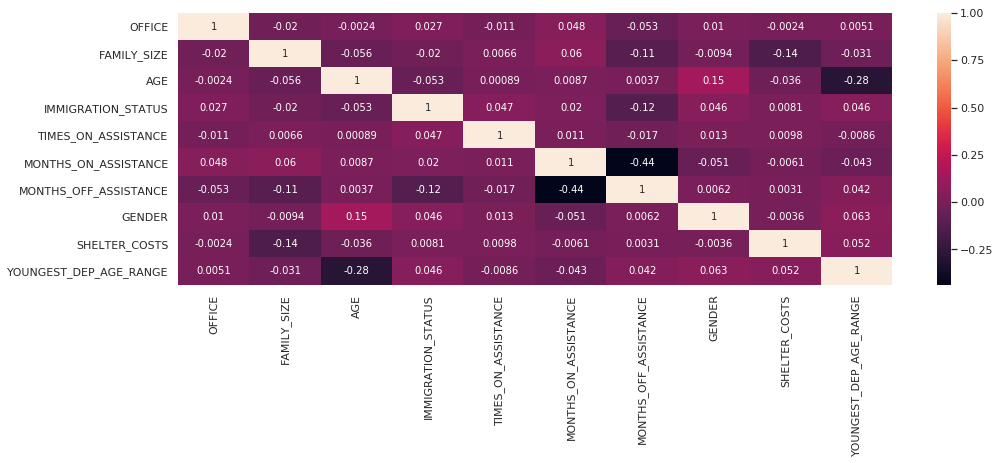

In [0]:
X.corr()
Var_Corr = X.corr()
plt.figure(figsize = (16,5))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

There is no multicollinearity observed among the variables. So we proceed with our data analysis and modelling.

**Scaling the data**

We are scaling our data such that each feature has unit variance. This is necessary because fitting algorithms highly depend on the scaling of the features. We have used the StandardScalermodule for scaling the features individually. StandardScalersubtracts the mean from each features and then scale to unit variance.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)
X_scaled


array([[-1.81906293, -1.20743323, -2.2598119 , ..., -0.79113514,
        -0.6648883 ,  0.49927627],
       [-1.81906293, -1.20743323, -2.2598119 , ..., -0.79113514,
        -0.12220925,  0.49927627],
       [-1.81906293, -1.20743323, -2.2598119 , ..., -0.79113514,
         0.4204698 ,  0.49927627],
       ...,
       [ 1.57666434,  1.79581581,  1.23903294, ...,  1.26397387,
         0.4204698 , -1.7046917 ],
       [ 1.57666434,  1.79581581,  1.23903294, ..., -0.79113514,
        -0.6648883 , -1.7046917 ],
       [ 1.57666434,  1.79581581,  2.11374415, ...,  1.26397387,
        -0.6648883 ,  1.23393226]])

So now we have a final dataset. In order to select the best features for classification, we would do PCA.

## **Principal component analysis**
PCA is essentially a method that reduces the dimension of the feature space in such a way that new variables are orthogonal to each other (i.e. they are independent or not correlated).


In [0]:
#fitting the scaled data in PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_scaled)


array([[ 1.07545735, -1.59237698,  1.37015494, ..., -1.41754717,
         1.34210711, -1.2263702 ],
       [ 1.12515192, -1.69478767,  1.09444032, ..., -1.07324421,
         1.31674503, -1.20845315],
       [ 1.17484649, -1.79719837,  0.8187257 , ..., -0.72894124,
         1.29138295, -1.1905361 ],
       ...,
       [-2.32422079,  1.56659065, -1.05985108, ...,  1.88727104,
         0.12821777,  1.18674196],
       [-2.95285868,  1.38624927,  0.25998008, ...,  0.99014997,
        -0.63323965,  1.4086905 ],
       [ 1.1304117 ,  0.95651545,  0.07177403, ...,  1.25778932,
        -2.1074173 ,  0.7232418 ]])

**Calculating the explained variance of each component**

In [0]:
covariance=pca.get_covariance()

In [0]:
explained_variance=pca.explained_variance_
explained_variance

array([1.50939149, 1.31973076, 1.14840726, 1.07904477, 1.01639548,
       0.97532105, 0.92695433, 0.83842032, 0.64102581, 0.54533934])

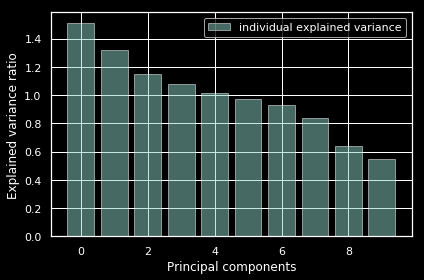

In [0]:
#plotting invidual explained variance
with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))
    
    plt.bar(range(10), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

Text(0, 0.5, 'Cumulative explained variance')

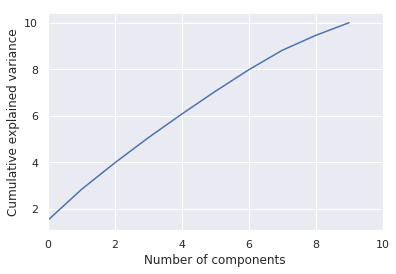

In [0]:
#plotting cumulative explained variance
from sklearn.decomposition import PCA
pca= PCA(n_components=10).fit_transform(X_scaled)
plt.plot(np.cumsum(explained_variance))
plt.xlim(0,10,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Here we see that more than 85% variance is explained by 8 components. So we will look at 8 components and derive the corresponding features from them

In [0]:
import pylab as pl
from sklearn import datasets
from sklearn.decomposition import PCA

# loading label encoded dataset
x = pd.DataFrame(data=X)

# normalizing data
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.scale(x),columns = x.columns) 

# PCA
pca = PCA(n_components=8)
X_pca=pca.fit_transform(data_scaled)


# Dumping components relations with features:
components=pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8'])

np.transpose(components)



,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8
OFFICE,-0.125455,-0.044700,-0.209211,-0.008694,-0.565237,-0.742596,-0.217129,0.141673
FAMILY_SIZE,-0.240501,0.002186,0.565540,0.353576,0.003655,0.048999,-0.154886,0.655595
AGE,-0.030093,0.694176,-0.239745,0.041222,-0.024951,0.058121,0.008811,-0.010461
IMMIGRATION_STATUS,-0.159893,-0.221210,-0.346336,0.393242,0.139305,-0.154141,0.739853,0.166714
TIMES_ON_ASSISTANCE,-0.050677,-0.016657,-0.152848,0.256014,0.741389,-0.409390,-0.425090,-0.100300
MONTHS_ON_ASSISTANCE,-0.644050,-0.041342,-0.070656,-0.179733,-0.018218,0.152631,-0.145844,-0.225003
MONTHS_OFF_ASSISTANCE,0.669941,0.073424,0.113149,0.019105,0.006838,-0.145382,0.014888,0.038301
GENDER,0.066945,0.175184,-0.394806,0.613685,-0.246828,0.356203,-0.296839,0.034881
SHELTER_COSTS,0.091573,-0.188713,-0.508062,-0.441799,0.146777,0.207322,-0.179892,0.634450
YOUNGEST_DEP_AGE_RANGE,0.144539,-0.627298,-0.061749,0.220369,-0.167217,0.192662,-0.242356,-0.237325


Using the FEATURES-COMPONENT table , we can derive the 8 features that we are going to use in our analysis.MONTHS_OFF_ASSISTANCE as PC-1, explains the most variance (66%). Similarly we look at PC-2(AGE-69%),PC-3(FAMILY_SIZE-56%),PC-4(GENDER-61%),PC-5(TIMES_ON_ASSISTANCE-74%),PC-6(OFFICE-74%),PC-7(IMMIGRATION_STATUS-73%),PC-8(SHELTER_COSTS-63%).

Using PCA as feature selection technique we derive the following features:

*   FAMILY_SIZE
*   AGE
* TIMES_ON_ASSISTANCE
*   MONTHS_OFF_ASSISTANCE
*   SHELTER_COSTS
* OFFICE
* IMMIGRATION_STATUS
* GENDER

We will drop MONTHS_ON_ASSISTANCE, YOUNGEST_DEP_AGE_RANGE





In [0]:
clsf= org.copy()
clsf['FAMILY_SIZE'] = np.where(clsf['FAMILY_SIZE'] =='4+',clsf['FAMILY_SIZE'],
                            np.where(clsf['FAMILY_SIZE'] =='4',clsf['FAMILY_SIZE'],
                                     np.where(clsf['FAMILY_SIZE'] =='3',clsf['FAMILY_SIZE'],
                                              np.where(clsf['FAMILY_SIZE'] =='2',clsf['FAMILY_SIZE'],'1'))))

clsf.rename(columns = {'OFF':'OFFICE','CASES                                    ':'CASES'}, inplace = True)



clsf.drop(["YEAR_NUM","MONTHS_ON_ASSISTANCE","YOUNGEST_DEP_AGE_RANGE","MNTH","PROGRAM_NM","EARNINGS","WARD_SCODE","CENSUS_NEIGH_SCODE","EDUCATION_LEVEL","FAMILY_TYP_NM",],axis =1 , inplace =True)
clsf_agg=clsf.groupby(["OFFICE", "FAMILY_SIZE", "AGE", "IMMIGRATION_STATUS","TIMES_ON_ASSISTANCE","MONTHS_OFF_ASSISTANCE","GENDER","SHELTER_COSTS"],as_index=False).sum()
clsf_agg.shape
clsf_agg['EXIT_BINARY']=np.where(clsf_agg['EXITS']==0,0 ,1)
clsf_agg.drop(["CASES","NEW_CASES"],axis=1,inplace=True)
clsf_agg.drop(["EXITS"],axis=1,inplace=True)

clsf=clsf_agg.copy()



# **DECISION TREE** 


In [0]:
#separating features and outcome variable
X1 = clsf.iloc[:,0:8]  # all rows, label only
y1=clsf['EXIT_BINARY'].to_frame()
X1.head()
y1.head()
X1.dtypes

OFFICE                   object
FAMILY_SIZE              object
AGE                      object
IMMIGRATION_STATUS       object
TIMES_ON_ASSISTANCE      object
MONTHS_OFF_ASSISTANCE    object
GENDER                   object
SHELTER_COSTS            object
dtype: object

In [0]:
X1.head()

,OFFICE,FAMILY_SIZE,AGE,IMMIGRATION_STATUS,TIMES_ON_ASSISTANCE,MONTHS_OFF_ASSISTANCE,GENDER,SHELTER_COSTS
0,Application Centre,1,16 to 17 yrs old,Canadian Citizen,1,1 to 6 months,F,$200 to $399
1,Application Centre,1,16 to 17 yrs old,Canadian Citizen,1,1 to 6 months,F,$400 to $599
2,Application Centre,1,16 to 17 yrs old,Canadian Citizen,1,1 to 6 months,F,$600 to $999
3,Application Centre,1,16 to 17 yrs old,Canadian Citizen,1,1 to 6 months,F,No shelter costs
4,Application Centre,1,16 to 17 yrs old,Canadian Citizen,1,1 to 6 months,M,$200 to $399


In [0]:
#performing one hot encoding as our variables are categorical
import category_encoders as ce
from google.colab import files

ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
X1 = ohe.fit_transform(X1)
X1.head()

,OFFICE_Application Centre,OFFICE_Attwell Employment & Social Services,OFFICE_Beaches Employment & Social Services,OFFICE_Chesswood Employment & Social Services,OFFICE_Client Special Services Unit,OFFICE_Consilium Employment & Social Services,OFFICE_Golden Mile Employment & Social Services,OFFICE_High Park Parkdale Employment & Social Services,OFFICE_Kennedy Employment & Social Services,OFFICE_Lawrence Square Employment & Social Services,OFFICE_Lesmill Employment & Social Services,OFFICE_Malvern Employment & Social Services,OFFICE_Metro Hall Employment & Social Services,OFFICE_The Queensway Employment & Social Services,OFFICE_Wellesley Place Employment & Social Services,OFFICE_Yonge Eglinton Employment & Social Services,OFFICE_York Humber Employment & Social Services,FAMILY_SIZE_1,FAMILY_SIZE_2,FAMILY_SIZE_3,FAMILY_SIZE_4,FAMILY_SIZE_4+,AGE_16 to 17 yrs old,AGE_18 to 29 yrs old,AGE_30 to 39 yrs old,AGE_40 to 49 yrs old,AGE_50 to 64 yrs old,AGE_65+ yrs old,AGE_Less than 16 yrs old,IMMIGRATION_STATUS_Canadian Citizen,IMMIGRATION_STATUS_Permanent Resident,IMMIGRATION_STATUS_Refugee Claimant,IMMIGRATION_STATUS_Visitor/Tourist/TempResVisitor/Student Visa,IMMIGRATION_STATUS_Minister Permit,IMMIGRATION_STATUS_No Status,TIMES_ON_ASSISTANCE_1,TIMES_ON_ASSISTANCE_2,TIMES_ON_ASSISTANCE_3,TIMES_ON_ASSISTANCE_4+,MONTHS_OFF_ASSISTANCE_1 to 6 months,MONTHS_OFF_ASSISTANCE_25 to 48 months,MONTHS_OFF_ASSISTANCE_49 to 120 months,MONTHS_OFF_ASSISTANCE_7 to 24 months,MONTHS_OFF_ASSISTANCE_over 120 months,GENDER_F,GENDER_M,GENDER_U,SHELTER_COSTS_$200 to $399,SHELTER_COSTS_$400 to $599,SHELTER_COSTS_$600 to $999,SHELTER_COSTS_No shelter costs,SHELTER_COSTS_Under $200,SHELTER_COSTS_$1000 to $1399,SHELTER_COSTS_$1400 to $1799,SHELTER_COSTS_over $1800
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


In [0]:
#training and testing by splitting our data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state = 1)

In [0]:
#counting the number of 0 and 1 in test and train to see if they are balanced.
num_zeros_t = (y_test == 0).sum()
num_ones_t = (y_test == 1).sum()
print("test y=0: ", num_zeros_t)
print("test y=1: ", num_ones_t)
num_zeros = (y_train == 0).sum()
num_ones = (y_train == 1).sum()
print("train y=0: ", num_zeros)
print("train y=1: ", num_ones)

test y=0:  EXIT_BINARY    11697
dtype: int64
test y=1:  EXIT_BINARY    7151
dtype: int64
train y=0:  EXIT_BINARY    46693
dtype: int64
train y=1:  EXIT_BINARY    28696
dtype: int64


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# Create Decision Tree classifer object
clf_DT1 = DecisionTreeClassifier(criterion="entropy", max_depth=10)

# Train Decision Tree Classifer
clf_DT1 = clf_DT1.fit(x_train,y_train)

#Predict the response for test dataset
y_pred_DT1 = clf_DT1.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_DT1))

Accuracy: 0.8352079796264855


In [0]:

#Applying cross validation to check what number of trees gives a better accuracy score
from sklearn.model_selection import cross_val_score

scores_DT2 = []

for val in range(1,15):
    clf_DT2 = DecisionTreeClassifier(criterion="entropy", max_depth=val)
    validated = cross_val_score(clf_DT2, x_train, y_train, cv=15)
    scores_DT2.append(validated)

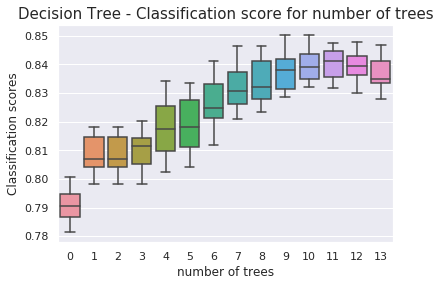

In [0]:
sns.boxplot(data=scores_DT2)
plt.xlabel('number of trees')
plt.ylabel('Classification scores')
plt.title('Decision Tree - Classification score for number of trees', fontsize=15)
plt.show()

We did a trial-and-error approach in the earlier section to see what depth specified for the Decision Tree gives better accuracy. Cross-validation approach was used to validate if the selected parameter was the right choice. The boxplots show that the accuracy tends to decrease after 10 number of trees. And the accuracy of the Decision Trees classifier in the earlier section is 83.5%.

In [0]:
#finding accuracy score,precision score and f1 score of the decision tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import plotly.plotly as py
import plotly.tools as tls

import matplotlib.pyplot as plt

print("Decision Tree Classification Metrics")
print(confusion_matrix(y_test,y_pred_DT1))  
print(classification_report(y_test,y_pred_DT1))
print(f1_score(y_test,y_pred_DT1))  

Decision Tree Classification Metrics
[[10246  1451]
 [ 1655  5496]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     11697
           1       0.79      0.77      0.78      7151

    accuracy                           0.84     18848
   macro avg       0.83      0.82      0.82     18848
weighted avg       0.83      0.84      0.83     18848

0.779685061710881


In [0]:
#visualizing decision tree
feature_names = list(X1.columns)
from sklearn.tree import export_graphviz

export_graphviz(clf_DT1, out_file="tree.dot", class_names=["Exit_yes", "Exit_no"],
 feature_names=feature_names, impurity=False, filled=True)

import graphviz
with open("tree.dot") as f:
 dot_graph = f.read()
graphviz.Source(dot_graph)


# **RANDOM FOREST**

In [0]:
#Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Instantiate model 
rf = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [25,50,100],
    'max_depth' : [5,10,15],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [True,False]
}

# Train the model on training data using GridSearch
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid)
CV_rfc.fit(x_train, y_train.values.ravel())


#Grid Search Best Parameters
CV_rfc.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



{'bootstrap': False, 'criterion': 'gini', 'max_depth': 15, 'n_estimators': 100}

In [0]:
#Initiate the model with GridSearch Parameters

rf_grid = RandomForestClassifier(n_estimators = 100, criterion = 'gini', max_depth = 15, 
                                 bootstrap=False,random_state=43)

# Train the model on training data
rf_grid.fit(x_train, y_train.values.ravel())
 
 
# Use the forest's predict method on the test data
predictions=rf_grid.predict(x_test)
 


In [0]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy: how often is the classifier correct?
print("Accuracy",round(metrics.accuracy_score(y_test.values.ravel(), predictions),4))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",round(metrics.precision_score(y_test.values.ravel(), predictions),3))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall",round(metrics.recall_score(y_test.values.ravel(), predictions),3))
print("F1-Score",round(metrics.f1_score(y_test.values.ravel(), predictions),3))

Accuracy 0.8441
Precision: 0.779
Recall 0.822
F1-Score 0.8


# **LOGISTIC REGRESSION**


           


The data is related with Ontario works assistance program. The classification goal is to predict if the client will Exit (1/0) assistance program. Our outcome variable is defined as EXIT_BINARY with Y/N


 It includes 9536341 records and 13 fields

In [0]:
print(h.shape)
print(list(h.columns))

In [0]:
h.head()

## **Data exploration and manipulation**
Using PCA we have identified our best 8 features. We will use those eight features in logistic regression and will drop others. 

In [0]:
lr = org.copy()
lr['FAMILY_SIZE'] = np.where(lr['FAMILY_SIZE'] =='4+',lr['FAMILY_SIZE'],
                            np.where(lr['FAMILY_SIZE'] =='4',lr['FAMILY_SIZE'],
                                     np.where(lr['FAMILY_SIZE'] =='3',lr['FAMILY_SIZE'],
                                              np.where(lr['FAMILY_SIZE'] =='2',lr['FAMILY_SIZE'],'1'))))

lr.rename(columns = {'OFF':'OFFICE','CASES                                    ':'CASES'}, inplace = True)

lr.drop(["YEAR_NUM","MONTHS_ON_ASSISTANCE","YOUNGEST_DEP_AGE_RANGE","MNTH","PROGRAM_NM","EARNINGS","WARD_SCODE","CENSUS_NEIGH_SCODE","EDUCATION_LEVEL","FAMILY_TYP_NM",],axis =1 , inplace =True)
lr_agg=lr.groupby(["OFFICE", "FAMILY_SIZE", "AGE", "IMMIGRATION_STATUS","TIMES_ON_ASSISTANCE","MONTHS_OFF_ASSISTANCE","GENDER","SHELTER_COSTS"],as_index=False).sum()

lr_agg['EXIT_BINARY'] = np.where(lr_agg['EXITS']==0,0 ,1)

lr_agg.drop(["NEW_CASES","EXITS","CASES"],axis =1 , inplace =True)

lr=lr_agg.copy()


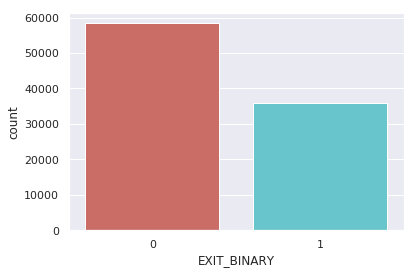

In [0]:
sns.countplot(x='EXIT_BINARY',data=lr, palette='hls')
plt.show()

our classes are looking balanced

## **Creating dummy variables**

In [0]:
df=pd.get_dummies(lr, columns=['OFFICE','AGE','IMMIGRATION_STATUS','TIMES_ON_ASSISTANCE','FAMILY_SIZE','MONTHS_OFF_ASSISTANCE','GENDER','SHELTER_COSTS',])

In [0]:
df.head()

,EXIT_BINARY,OFFICE_Application Centre,OFFICE_Attwell Employment & Social Services,OFFICE_Beaches Employment & Social Services,OFFICE_Chesswood Employment & Social Services,OFFICE_Client Special Services Unit,OFFICE_Consilium Employment & Social Services,OFFICE_Golden Mile Employment & Social Services,OFFICE_High Park Parkdale Employment & Social Services,OFFICE_Kennedy Employment & Social Services,OFFICE_Lawrence Square Employment & Social Services,OFFICE_Lesmill Employment & Social Services,OFFICE_Malvern Employment & Social Services,OFFICE_Metro Hall Employment & Social Services,OFFICE_The Queensway Employment & Social Services,OFFICE_Wellesley Place Employment & Social Services,OFFICE_Yonge Eglinton Employment & Social Services,OFFICE_York Humber Employment & Social Services,AGE_16 to 17 yrs old,AGE_18 to 29 yrs old,AGE_30 to 39 yrs old,AGE_40 to 49 yrs old,AGE_50 to 64 yrs old,AGE_65+ yrs old,AGE_Less than 16 yrs old,IMMIGRATION_STATUS_Canadian Citizen,IMMIGRATION_STATUS_Minister Permit,IMMIGRATION_STATUS_No Status,IMMIGRATION_STATUS_Permanent Resident,IMMIGRATION_STATUS_Refugee Claimant,IMMIGRATION_STATUS_Visitor/Tourist/TempResVisitor/Student Visa,TIMES_ON_ASSISTANCE_1,TIMES_ON_ASSISTANCE_2,TIMES_ON_ASSISTANCE_3,TIMES_ON_ASSISTANCE_4+,FAMILY_SIZE_1,FAMILY_SIZE_2,FAMILY_SIZE_3,FAMILY_SIZE_4,FAMILY_SIZE_4+,MONTHS_OFF_ASSISTANCE_1 to 6 months,MONTHS_OFF_ASSISTANCE_25 to 48 months,MONTHS_OFF_ASSISTANCE_49 to 120 months,MONTHS_OFF_ASSISTANCE_7 to 24 months,MONTHS_OFF_ASSISTANCE_over 120 months,GENDER_F,GENDER_M,GENDER_U,SHELTER_COSTS_$1000 to $1399,SHELTER_COSTS_$1400 to $1799,SHELTER_COSTS_$200 to $399,SHELTER_COSTS_$400 to $599,SHELTER_COSTS_$600 to $999,SHELTER_COSTS_No shelter costs,SHELTER_COSTS_Under $200,SHELTER_COSTS_over $1800
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [0]:
X2 =df.iloc[:,1:56]  # all rows, label only
y2= df.iloc[:,0:1]
X2.head()
y2.head()

,EXIT_BINARY
0,0
1,0
2,0
3,0
4,0


## **Recursive feature elimination**

In [0]:
list(X2)

['OFFICE_Application Centre',
 'OFFICE_Attwell Employment & Social Services',
 'OFFICE_Beaches Employment & Social Services',
 'OFFICE_Chesswood Employment & Social Services',
 'OFFICE_Client Special Services Unit',
 'OFFICE_Consilium Employment & Social Services',
 'OFFICE_Golden Mile Employment & Social Services',
 'OFFICE_High Park Parkdale Employment & Social Services',
 'OFFICE_Kennedy Employment & Social Services',
 'OFFICE_Lawrence Square Employment & Social Services',
 'OFFICE_Lesmill Employment & Social Services',
 'OFFICE_Malvern Employment & Social Services',
 'OFFICE_Metro Hall Employment & Social Services',
 'OFFICE_The Queensway Employment & Social Services',
 'OFFICE_Wellesley Place Employment & Social Services',
 'OFFICE_Yonge Eglinton Employment & Social Services',
 'OFFICE_York Humber Employment & Social Services',
 'AGE_16 to 17 yrs old',
 'AGE_18 to 29 yrs old',
 'AGE_30 to 39 yrs old',
 'AGE_40 to 49 yrs old',
 'AGE_50 to 64 yrs old',
 'AGE_65+ yrs old',
 'AGE_Less

In [0]:

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

rfe = RFE(logreg, 20)
rfe = rfe.fit(X2, y2.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False False False  True False False False False False False False
 False False False False False  True False False False False  True  True
  True  True  True False False  True False False  True False  True False
 False False False  True  True  True False  True False False  True False
  True False False False  True  True  True]
[ 1 27 34 32  1 14 12 35 21 28 25 11  6 31 30 29 26  1 19 17 18 33  1  1
  1  1  1  5 15  1 16  2  1 36  1 20 13  7  4  1  1  1  3  1  9  8  1 24
  1 23 22 10  1  1  1]


The Recursive Feature Elimination (RFE) has helped us select the following features:

'AGE_16 to 17 yrs old'

 'AGE_65+ yrs old'   
 'AGE_Less than 16 yrs old' 
 'FAMILY_SIZE_1'

 'GENDER_U'

 'IMMIGRATION_STATUS_Canadian Citizen'

 'IMMIGRATION_STATUS_Minister Permit'

 'IMMIGRATION_STATUS_No Status'

 'IMMIGRATION_STATUS_Visitor/Tourist/TempResVisitor/Student Visa'

 'MONTHS_OFF_ASSISTANCE_1 to 6 months'

 'MONTHS_OFF_ASSISTANCE_25 to 48 months'

 'MONTHS_OFF_ASSISTANCE_49 to 120 months'

 'MONTHS_OFF_ASSISTANCE_over 120 months'

 'OFFICE_Client Special Services Unit'

 'SHELTER_COSTS_1400 to 1799'

 'SHELTER_COSTS_No shelter costs'

 'SHELTER_COSTS_over 1800'

 'SHELTER_COSTS_Under 200'

 'TIMES_ON_ASSISTANCE_3'







In [0]:
#dropping 35 columns
X2.drop(['AGE_18 to 29 yrs old', 'AGE_30 to 39 yrs old', 'AGE_40 to 49 yrs old', 'AGE_50 to 64 yrs old', 'FAMILY_SIZE_2', 'FAMILY_SIZE_3', 'FAMILY_SIZE_4', 'FAMILY_SIZE_4+', 'GENDER_F', 'GENDER_M', 'IMMIGRATION_STATUS_Permanent Resident', 'IMMIGRATION_STATUS_Refugee Claimant', 'MONTHS_OFF_ASSISTANCE_7 to 24 months', 'OFFICE_Attwell Employment & Social Services', 'OFFICE_Beaches Employment & Social Services', 'OFFICE_Chesswood Employment & Social Services', 'OFFICE_Consilium Employment & Social Services', 'OFFICE_Golden Mile Employment & Social Services', 'OFFICE_High Park Parkdale Employment & Social Services', 'OFFICE_Kennedy Employment & Social Services', 'OFFICE_Lawrence Square Employment & Social Services', 'OFFICE_Lesmill Employment & Social Services', 'OFFICE_Malvern Employment & Social Services', 'OFFICE_Metro Hall Employment & Social Services', 'OFFICE_The Queensway Employment & Social Services', 'OFFICE_Wellesley Place Employment & Social Services', 'OFFICE_Yonge Eglinton Employment & Social Services', 'OFFICE_York Humber Employment & Social Services', 'SHELTER_COSTS_$1000 to $1399', 'SHELTER_COSTS_$200 to $399', 'SHELTER_COSTS_$400 to $599', 'SHELTER_COSTS_$600 to $999', 'TIMES_ON_ASSISTANCE_1', 'TIMES_ON_ASSISTANCE_2', 'TIMES_ON_ASSISTANCE_4+'],axis=1,inplace=True)

In [0]:
X2.head()

,OFFICE_Application Centre,OFFICE_Client Special Services Unit,AGE_16 to 17 yrs old,AGE_65+ yrs old,AGE_Less than 16 yrs old,IMMIGRATION_STATUS_Canadian Citizen,IMMIGRATION_STATUS_Minister Permit,IMMIGRATION_STATUS_No Status,IMMIGRATION_STATUS_Visitor/Tourist/TempResVisitor/Student Visa,TIMES_ON_ASSISTANCE_3,FAMILY_SIZE_1,MONTHS_OFF_ASSISTANCE_1 to 6 months,MONTHS_OFF_ASSISTANCE_25 to 48 months,MONTHS_OFF_ASSISTANCE_49 to 120 months,MONTHS_OFF_ASSISTANCE_over 120 months,GENDER_U,SHELTER_COSTS_$1400 to $1799,SHELTER_COSTS_No shelter costs,SHELTER_COSTS_Under $200,SHELTER_COSTS_over $1800
0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0
4,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0


## Implementing the **model**

In [0]:
import statsmodels.api as sm
logit_model=sm.Logit(y2,X2)
result=logit_model.fit()
print(result.summary2())



         Current function value: 0.460194
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                                 Results: Logit
Model:                              Logit                            Pseudo R-squared:                 0.307     
Dependent Variable:                 EXIT_BINARY                      AIC:                              86774.6398
Date:                               2019-07-29 05:15                 BIC:                              86963.7112
No. Observations:                   94237                            Log-Likelihood:                   -43367.   
Df Model:                           19                               LL-Null:                          -62597.   
Df Residuals:                       94217                            LLR p-value:                      0.0000    
Converged:                          0.0000                           Scale:                            1.0000    
No. Iterations:                     35.0000                                                                      
------------------------

## Logistic Regression Model **Fitting**

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test_lr = train_test_split(X2, y2, test_size=0.3, random_state=0)
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test_lr)))

Accuracy of logistic regression classifier on test set: 0.83


In [0]:
# 10-fold cross-validation with logistic regression
print(cross_val_score(logreg, X2, y2.values.ravel(), cv=10, scoring='accuracy').mean())

0.8207388820061883


### Confusion **Matrix**

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_lr, y_pred)
print(confusion_matrix)

[[14682  2685]
 [ 2245  8660]]


In [0]:
#printing classification report of logistic regression providing precision,recall,f1-score
from sklearn.metrics import classification_report
print(classification_report(y_test_lr, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     17367
           1       0.76      0.79      0.78     10905

    accuracy                           0.83     28272
   macro avg       0.82      0.82      0.82     28272
weighted avg       0.83      0.83      0.83     28272



In [0]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy: 
print("Accuracy",round(metrics.accuracy_score(y_test_lr, y_pred),4))

# Model Precision: 
print("Precision:",round(metrics.precision_score(y_test_lr, y_pred),3))

# Model Recall: 
print("Recall",round(metrics.recall_score(y_test_lr, y_pred),3))
print("F1-Score",round(metrics.f1_score(y_test_lr, y_pred),3))

Accuracy 0.8256
Precision: 0.763
Recall 0.794
F1-Score 0.778


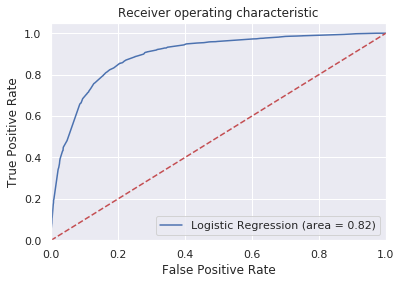

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test_lr, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test_lr, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Comparing decision tree and logistic regression 

In [0]:
DT_acc = accuracy_score(y_test,predictions)
DT_prec = precision_score(y_test,predictions)
DT_rec = recall_score(y_test,predictions)
DT_f1 = f1_score(y_test,predictions)

y_ax_dt = np.array([DT_acc,DT_prec,DT_rec,DT_f1])
x_ax_dt = ['Accuracy','Precision','Recall','F1']
clf_dt = ['Decision Tree','Decision Tree','Decision Tree','Decision Tree']


d_dt = {'Metrics':x_ax_dt,'Scores':y_ax_dt, 'Classifier':clf_dt }
df_dt = pd.DataFrame(d_dt, columns=['Metrics', 'Scores', 'Classifier'])

In [0]:
LR_acc = accuracy_score(y_test_lr,y_pred)
LR_prec = precision_score(y_test_lr,y_pred)
LR_rec = recall_score(y_test_lr,y_pred)
LR_f1 = f1_score(y_test_lr,y_pred)

y_ax_lr = np.array([LR_acc,LR_prec,LR_rec,LR_f1])
x_ax_lr = ['Accuracy','Precision','Recall','F1']
clf_lr = ['Logistic Regression','Logistic Regression','Logistic Regression','Logistic Regression']



d_lr = {'Metrics':x_ax_lr,'Scores':y_ax_lr, 'Classifier':clf_lr}


df_lr = pd.DataFrame(d_lr, columns=['Metrics', 'Scores', 'Classifier'])
df_all = df_dt.append(df_lr, ignore_index=True)

In [0]:
df_all.head(20)


,Metrics,Scores,Classifier
0,Accuracy,0.844121,Decision Tree
1,Precision,0.779192,Decision Tree
2,Recall,0.822123,Decision Tree
3,F1,0.800082,Decision Tree
4,Accuracy,0.825623,Logistic Regression
5,Precision,0.763332,Logistic Regression
6,Recall,0.794131,Logistic Regression
7,F1,0.778427,Logistic Regression


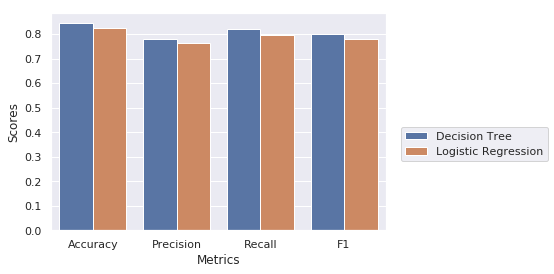

In [0]:

ax=sns.barplot(x='Metrics', y='Scores', hue='Classifier', data=df_all)


ax.legend(bbox_to_anchor=(1.5, 0.5))

plt.show()